# Install dependencies

In [2]:
%pip install autogen-ext[openai]==0.4.6 autogen[graphs]==0.7.4 matplotlib==3.10.0 autogen-agentchat[graph]==0.4.6 networkx==3.4.2 httpx==0.28.1

zsh:1: no matches found: autogen-ext[openai]==0.4.6
Note: you may need to restart the kernel to use updated packages.


# Setup Environment

In [4]:
import os

os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

config_list = [{'model': 'gpt-4o-mini', 'api_key': os.environ['OPENAI_API_KEY']}]
llm_config = {'config_list': config_list, 'cache_seed': 45}

# Setup Agents

In [5]:
import json
import autogen
from autogen.agentchat.contrib.gpt_assistant_agent import GPTAssistantAgent
import httpx
from autogen.function_utils import get_function_schema


def get_players() -> str:
    result = httpx.Client().get('http://localhost:8081/players')
    return json.dumps(result.json())


def get_landmarks() -> str:
    result = httpx.Client().get('http://localhost:8081/landmarks')
    return json.dumps(result.json())


def get_trains() -> str:
    result = httpx.Client().get('http://localhost:8081/trains')
    return json.dumps(result.json())


player_schema = get_function_schema(
    get_players,
    name=get_players.__name__,
    description='Returns real-time data of all players, Team, Country, Salary, etc.',
)

landmark_schema = get_function_schema(
    get_landmarks,
    name=get_landmarks.__name__,
    description='Returns real-time data of all landmarks places etc.',
)

train_schema = get_function_schema(
    get_trains,
    name=get_trains.__name__,
    description='Returns real-time data of all train locomotives classified from Class M1 - M11',
)

sport_agent_config = {
    'tools': [
        player_schema
    ],
    'use_tool_output': True
}

landmark_agent_config = {
    'tools': [
        landmark_schema
    ],
    'use_tool_output': True
}

train_agent_config = {
    'tools': [
        train_schema
    ],
    'use_tool_output': True
}

sport_agent = GPTAssistantAgent(
    name='sport_agent',
    instructions='I\'m an sport agent having ability to fetch real time data about people, players, teams, countries, salary, etc.',
    llm_config=llm_config,
    assistant_config=sport_agent_config,
)

landmark_agent = GPTAssistantAgent(
    name='landmark_agent',
    instructions='I\'m an landmark agent having ability to fetch real time data about places, landmarks.',
    llm_config=llm_config,
    assistant_config=landmark_agent_config,
)

train_agent = GPTAssistantAgent(
    name='train_agent',
    instructions='I\'m an train agent having ability to fetch real time data about locomotives Classified from Class M1 - M11',
    llm_config=llm_config,
    assistant_config=train_agent_config,
)

supervisor = autogen.UserProxyAgent(
    name='Supervisor',
    system_message='A human supervisor.',
    human_input_mode='NEVER',
    is_termination_msg=lambda x: x.get('content', '') and x.get('content', '').rstrip().endswith('TERMINATE'),
)

sport_agent.register_function({
    'get_players': get_players,
})

landmark_agent.register_function({
    'get_landmarks': get_landmarks,
})

train_agent.register_function({
    'get_trains': get_trains,
})

OpenAI client config of GPTAssistantAgent(sport_agent) - model: gpt-4o-mini
instructions not match, skip assistant(asst_y6JH3G2KvSj7GSfrhqTQHryJ): I'm an sport agent having ability to fetch real time data about players, teams, countries, salary, etc.
Matching assistant found, using the first matching assistant: {'id': 'asst_j865oWWYK82tmuHq2OzwH1TA', 'created_at': 1739882360, 'description': None, 'instructions': "I'm an sport agent having ability to fetch real time data about people, players, teams, countries, salary, etc.", 'metadata': {}, 'model': 'gpt-4o-mini', 'name': 'sport_agent', 'object': 'assistant', 'tools': [FunctionTool(function=FunctionDefinition(name='get_players', description='Returns real-time data of all players, Team, Country, Salary, etc.', parameters={'type': 'object', 'properties': {}, 'required': []}, strict=False), type='function')], 'response_format': 'auto', 'temperature': 1.0, 'tool_resources': ToolResources(code_interpreter=None, file_search=None), 'top_p': 1

# Create Graph

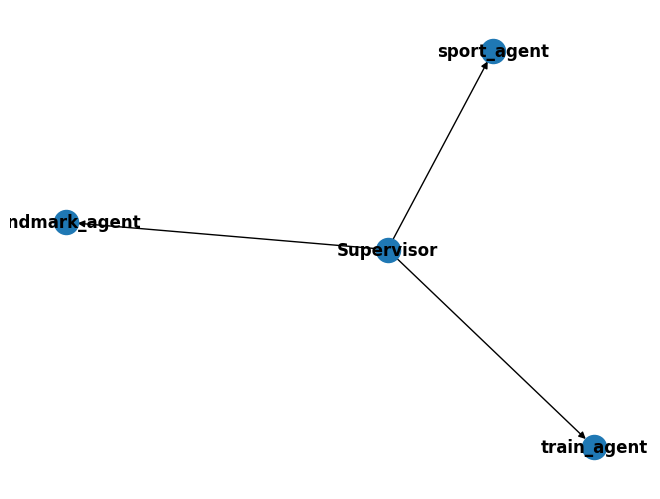

In [6]:
from autogen.graph_utils import visualize_speaker_transitions_dict

chat_agents = [supervisor, sport_agent, landmark_agent, train_agent]
allowed_speaker_dict = {supervisor: [sport_agent, landmark_agent, train_agent]}

visualize_speaker_transitions_dict(allowed_speaker_dict, chat_agents)

# Create Group Chat

In [7]:
from autogen import GroupChat, GroupChatManager

group_chat = GroupChat(agents=chat_agents, messages=[], max_round=25, allowed_or_disallowed_speaker_transitions=allowed_speaker_dict, allow_repeat_speaker=None,
                       speaker_transitions_type='allowed')

chat_manager = GroupChatManager(
    groupchat=group_chat,
    llm_config=llm_config,
    is_termination_msg=lambda x: x.get('content', '') and x.get('content', '').rstrip().endswith('TERMINATE'),
    code_execution_config=False,
)

# Test

In [8]:
supervisor.initiate_chat(
    chat_manager,
    message='What\'s the age of Sean Manaea?',
)

Supervisor (to chat_manager):

What's the age of Sean Manaea?

--------------------------------------------------------------------------------

Next speaker: sport_agent


>>>>>>>> EXECUTING FUNCTION get_players...
Call ID: call_NPwALdnOtwaxI15wm0yumLwN
Input arguments: {}
sport_agent (to chat_manager):

Sean Manaea is 32 years old.


--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': "What's the age of Sean Manaea?", 'role': 'assistant', 'name': 'Supervisor'}, {'content': 'Sean Manaea is 32 years old.\n', 'name': 'sport_agent', 'role': 'user'}], summary='Sean Manaea is 32 years old.\n', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])

In [10]:
supervisor.initiate_chat(
    chat_manager,
    message='What\'s the completion year of Pyramids of Giza',
)

Supervisor (to chat_manager):

What's the completion year of Pyramids of Giza

--------------------------------------------------------------------------------

Next speaker: landmark_agent

landmark_agent (to chat_manager):

The Pyramids of Giza were completed around 2560 BCE. The Great Pyramid of Giza, in particular, is the largest and was built as a tomb for the Pharaoh Khufu.


--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': "What's the completion year of Pyramids of Giza", 'role': 'assistant', 'name': 'Supervisor'}, {'content': 'The Pyramids of Giza were completed around 2560 BCE. The Great Pyramid of Giza, in particular, is the largest and was built as a tomb for the Pharaoh Khufu.\n', 'name': 'landmark_agent', 'role': 'user'}], summary='The Pyramids of Giza were completed around 2560 BCE. The Great Pyramid of Giza, in particular, is the largest and was built as a tomb for the Pharaoh Khufu.\n', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])

In [9]:
supervisor.initiate_chat(
    chat_manager,
    message='What\'s the the engine used in M9?',
)

Supervisor (to chat_manager):

What's the the engine used in M9?

--------------------------------------------------------------------------------

Next speaker: train_agent


>>>>>>>> EXECUTING FUNCTION get_trains...
Call ID: call_SysgGjRQcw5u1gD2TF1J943R
Input arguments: {}
train_agent (to chat_manager):

The engine used in Class M9 locomotives is the **AD32C**. It was manufactured by Alstom in the year 2000 and is classified under the axle arrangement Co-Co, with a maximum power of 1800 hp.


--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': "What's the the engine used in M9?", 'role': 'assistant', 'name': 'Supervisor'}, {'content': 'The engine used in Class M9 locomotives is the **AD32C**. It was manufactured by Alstom in the year 2000 and is classified under the axle arrangement Co-Co, with a maximum power of 1800 hp.\n', 'name': 'train_agent', 'role': 'user'}], summary='The engine used in Class M9 locomotives is the **AD32C**. It was manufactured by Alstom in the year 2000 and is classified under the axle arrangement Co-Co, with a maximum power of 1800 hp.\n', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])